In [1]:
import numpy as np
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/1/21,5/2/21,5/3/21,5/4/21,5/5/21,5/6/21,5/7/21,5/8/21,5/9/21,5/10/21
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,59939,60122,60300,60563,60797,61162,61455,61755,61842,62063
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,131185,131238,131276,131327,131419,131510,131577,131666,131723,131753
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,122311,122522,122717,122999,123272,123473,123692,123900,124104,124288
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,13232,13282,13295,13316,13340,13363,13390,13406,13423,13429
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,26815,26993,27133,27284,27529,27921,28201,28477,28740,28875


# Python modeling of the impact of social distancing and early termination of lockdown
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536
---

## What is this demo about?
The greatest [global crisis since World War II](https://www.bloomberg.com/opinion/articles/2020-03-24/coronavirus-recession-it-will-be-a-lot-like-world-war-ii) and the [largest global pandemic since the 1918–19 Spanish Flu](https://www.cdc.gov/flu/pandemic-resources/1918-pandemic-h1n1.html) is upon us today. Everybody is looking at the [daily rise of the death toll](https://www.worldometers.info/coronavirus/worldwide-graphs/) and the rapid, [exponential spread](https://www.forbes.com/sites/startswithabang/2020/03/17/why-exponential-growth-is-so-scary-for-the-covid-19-coronavirus/#2bf6b23f4e9b) of this novel strain of the virus.

Data scientists, like so many people from all other walks of life, may also be feeling anxious. They may also be eager to see if they can contribute somehow to the fight against this highly infectious pathogen.

There can be many avenues for data scientists and statistical modeling professionals to contribute to the cause. **In almost all cases, they should be working closely with domain experts - virologists, healthcare professionals, epidemiologists. Without such active collaboration and teamwork, it is dangerous and meaningless to embark on a project of predictive modeling or forecasting the spread of the disease and mitigation efforts**.

However, even without venturing into actual predictive modeling, it is possible to demonstrate the efficacy of the only basic weapon that we all have against the COVID-19 virus - ___["social distancing"](https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/social-distancing.html)___ - by a simple programmatic approach.

In this demo, we will show how to build such a demo in Python, following a simple yet fundamental epidemiological theory.

This is not an attempt to build any forecasting or predictive model. **No actual data**, other than some fictitious numbers, will be used to generate the plots and visualizations.

The goal is to show that **with only a basic dynamical model**, it is possible to understand key concepts such as the **_"flattening the curve"_**, **_"herd immunity"_**, and **_"lifting the lockdown too quickly"_**. And, you can program such a model with rudimentary python and mathematical knowledge.

---

## The basic epidemiology model class

### A reference article
We created a Python class called `SEIRclass` based on the [SEIR model of basic epidemiology](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology). The script is in the `SEIRclass.py` file and the class needs to be imported for this demo.

![seir-1](https://raw.githubusercontent.com/tirthajyoti/Covid-19-analysis/master/images/SEIR-1.png)

The idea is inspired by this article which lays down the epidemiological model and the dynamical equations clearly: **[Social Distancing to Slow the Coronavirus](https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296)**

Here is the Github repo corresponding to the article above: https://github.com/dgoldman0/socialdistancing

### Dynamical equations

The basic dynamical equations are as follows,

$$\frac{dS}{dt} = -\beta.S.I $$

$$\frac{dE}{dt} = \beta.S.I - \alpha.E$$

$$\frac{dI}{dt} = \alpha.E - \gamma.I$$

$$\frac{dR}{dt} = \gamma.I$$

where,

- $\alpha$ is the inverse of the virus incubation period
- $\beta$ is the average contact rate in the population
- $\gamma$ is the inverse of the mean infectious period
- S, E, I, and R represent the fraction of population in the _Susceptible_, _Exposed_, _Infected_, and _Recovered_ categories.

The first two equations changes slightly with the introduction of a fourth parameters $\rho$ which represents the social mixing. The higher the $/rho$ the less social distancing. It can have a value from 0 to 1.

$$\frac{dS}{dt} = -\rho.\beta.S.I $$

$$\frac{dE}{dt} = \rho.\beta.S.I - \alpha.E$$

### The core Python class

Partial class definition is shown below,

```python
# SEIR model class definition
# Dr. Tirthajyoti Sarkar, Fremont, CA
# April 2020

import numpy as np
import matplotlib.pyplot as plt

class SEIR:
    def __init__(self,
                 init_vals=[1 - 1/1000, 1/1000, 0, 0], 
                 params_=[0.2,1.75,0.5,0.9]):
        """
        Initializes and sets the initial lists and parameters
        """
        # Initial values
        self.s0 = init_vals[0]
        self.e0 = init_vals[1]
        self.i0 = init_vals[2]
        self.r0 = init_vals[3]
        # Lists
        self.s, self.e, self.i, self.r = [self.s0], [self.e0], [self.i0], [self.r0]
        # Dynamical parameters
        self.alpha = params_[0]
        self.beta = params_[1]
        self.gamma = params_[2]
        self.rho = params_[3]
        # All parameters together in a list
        self.params_ = [self.alpha,self.beta,self.gamma,self.rho]
        # All final values together in a list
        self.vals_ = [self.s[-1], self.e[-1], self.i[-1], self.r[-1]]
```

### Various methods

We define various utility methods in this class,

- `reinitialize`: Re-initializes the model with new values (of population)
- `set_params`: Sets the dynamical parameters value
- `reset`: Resets the internal lists to zero-state i.e. initial values
- `run`: Runs the dynamical simulation for a given amount of time (with a given time step delta)
- `plot`: Plots the basic results of the simulation on a time-axis


## Demo
### Import the class and examine parameters/variables

In [1]:
from SIR import *
import numpy as np

### Run simulation for various social distancing factors
Note that, here, **higher value means less social distancing i.e. higher social mixing/interactions**.

We observe that **higher degree of social mixing leads to higher peak for the infected population fraction**, which can potentially overwhelm the healthcare system capacity.

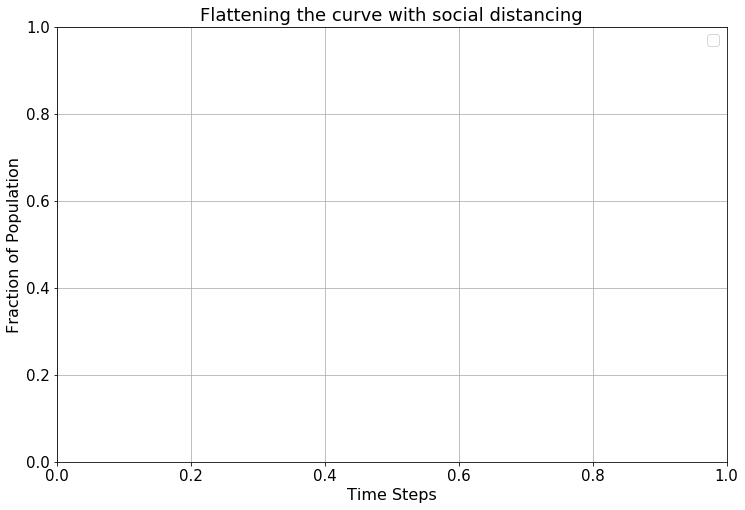

In [5]:
social_dist = [0.4,0.5,0.6,0.7,0.8]
plt.figure(figsize=(12,8))
for d in social_dist:
    s = Learner("India", 0.01)
    s.rho=d
plt.title('Flattening the curve with social distancing',fontsize=18)
plt.legend(["Social distancing factor: "+str(d) for d in social_dist],
           fontsize=15)
plt.xlabel('Time Steps',fontsize=16)
plt.ylabel('Fraction of Population',fontsize=16)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Tweaking social distancing

Now, we examine what happens with early termination of lockdown or "stay-at-home" measures, which aim to reduce social mixing i.e. increase social distancing.

We start with a certain value of the social distancing factor, let it run for a certain amount of time, and then relax the norms i.e. increase the value of the social distancing factor, and see what happens to the infected population fraction. **We will observe a second peak appearing**. Depending on social and epidemiological factors, this second peak can be higher than the first one.

For this study, we will use two SEIR models, 
- The first model will run for a certain amount of time with a low social mixing factor (strict social distancing norm)
- The final values of the population proportion from this model will be fed into the second model.
- The second model will run with a higher value of social mixing (relaxed social distancing norm)

### Parameters

We will use this set of parameters for modeling the disease spread for this experiment.

In [12]:
p = [0.7,2.1,0.7,0.1]

### First model with the parameters and default initial values

In [13]:
s1 = SEIR(params_=p)

### Set 'social distancing factor' to 0.4 (i.e. 40% interaction, stay-at-home measures are working)

In [14]:
s1.rho=0.4

### Run the simulation for 90 time units

In [15]:
r1=s1.run(t_max=90,dt=0.1)

### Capture the final values as the new initial values for the next model

In [16]:
new_init = s1.vals_

### New model with the final values from the previous model as the initial values

In [17]:
s2 = SEIR(init_vals=new_init,
          params_=p)

### Relaxing the 'social distancing factor' to 0.9 (social mixing is happening up to 90%)

In [18]:
s2.rho = 0.9

### Run the simulation for another 90 time units
Note that we put `reset=False` for this simulation

In [19]:
r2=s2.run(t_max=90,dt=0.1,reset=False)

### Aggregating both results (adding simulated values up to 90+90 = 180 time units)

In [20]:
r3=np.vstack((r1,r2))

### Plotting only the infected fraction
Note the two peaks. The first peak was subsiding when social distancing was relaxed and the second - a much higher peak - came upon us!

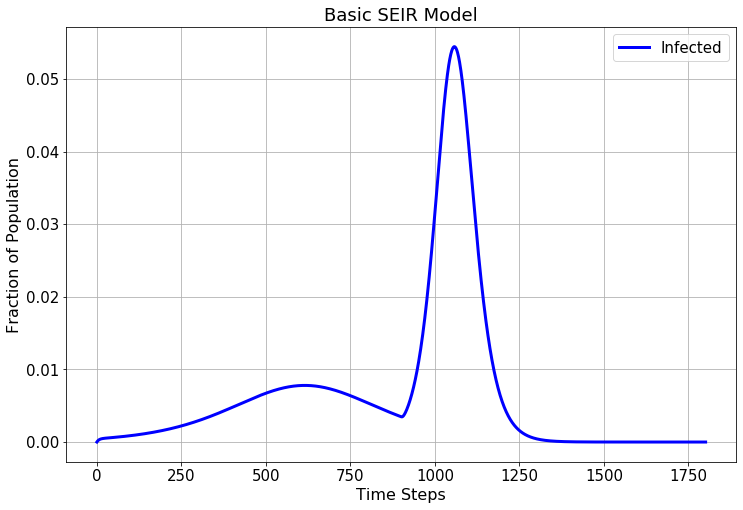

In [21]:
s2.plot_var(r3[:,2],var_name='Infected')

### "Herd immunity" - letting first 'lockdown' run for a longer time helps to reduce both peaks

We also observe that letting the first 'lockdown' run for a longer time can potentially reduce the absolute value of both peaks. This is due to the fact of ___"herd immunity"___ i.e. **with a longer lockdown, the susceptible population gradually reduces slowly over time** and therefore when the lockdown is relaxed, there is less susceptible population for the virus to infect!

We also note that beyond 150 days, the susceptible fraction level does not go down significantly i.e. there is no visible reduction from 150 days case to the 180 days case to the 210 days case. Therefore, **if the goal is to build herd immunity, the lockdown extension may be effective only up to a certain period**.

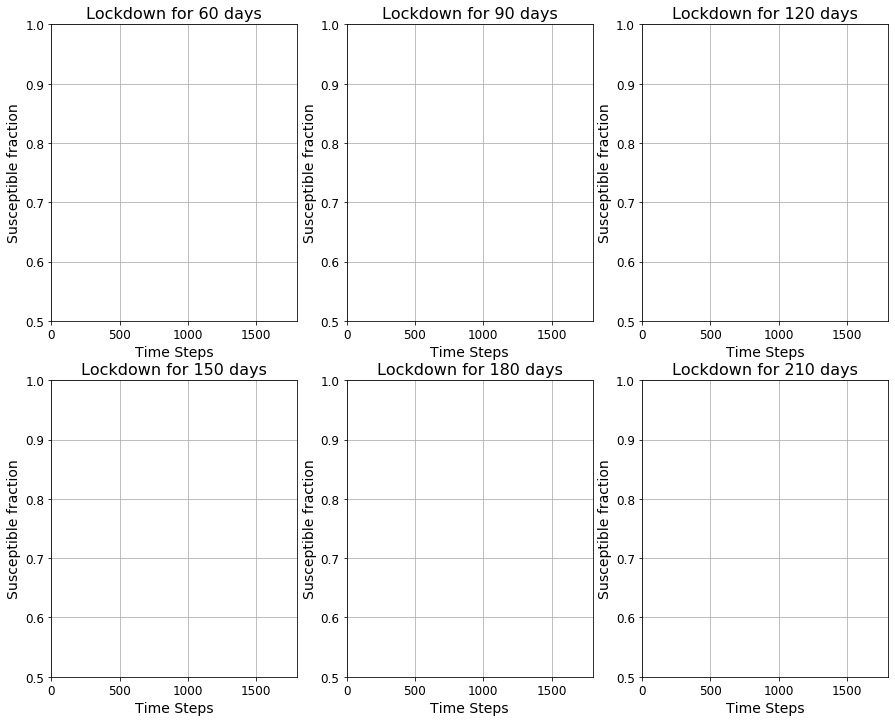

In [11]:
p = [0.7,2.1,0.7,0.4]
days = [60,90,120,150,180,210]
#s = Learner(params_=p)
fig,ax=plt.subplots(2,3,figsize=(15,12))
axes = ax.ravel()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for i,d in enumerate(days):
    #r=s.run(t_max=d,dt=0.1)
    #axes[i].plot(r[:,0],lw=3)
    axes[i].set_title('Lockdown for {} days'.format(d),fontsize=16)
    axes[i].set_xlabel('Time Steps',fontsize=14)
    axes[i].set_ylabel('Susceptible fraction',fontsize=14)
    axes[i].set_xlim(0,1800)
    axes[i].set_ylim(0.5,1.0)
    axes[i].grid(True)
    axes[i].tick_params(labelsize=12)
plt.show()

### Reduce peaks by letting the first lockdown run longer
The example of 'tweaking social distancing' above showed a second peak of as high as > 0.05 i.e. 5% of the population getting infected. Here, we show that letting the first lockdown running longer can potentially reduce both peaks. In fact, we see the first peak is higher in this experiment and it is only around 0.018 or 1.8%.

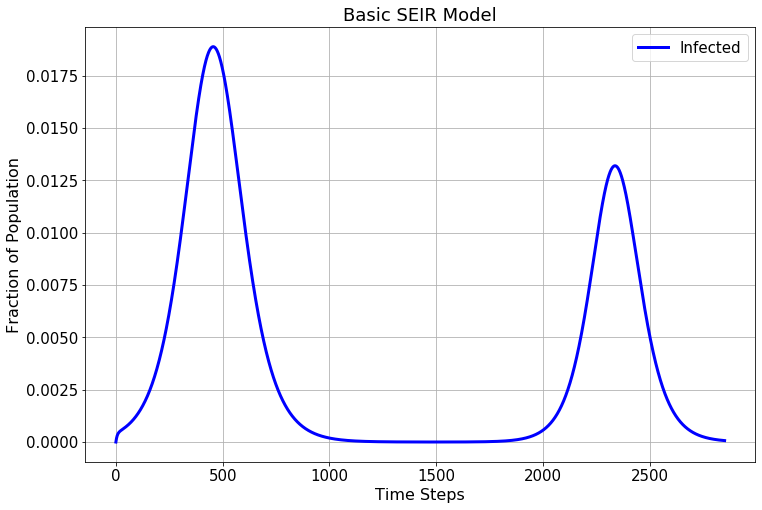

In [25]:
s1 = SEIR(params_=p)
s1.rho=0.45
r1=s1.run(t_max=150,dt=0.1)
new_init = s1.vals_
s2 = SEIR(init_vals=new_init,
          params_=p)
s2.rho = 0.9
r2=s2.run(t_max=135,dt=0.1,reset=False)
r3=np.vstack((r1,r2))
s2.plot_var(r3[:,2],var_name='Infected')